# Trabalho 3
Descrição do trabalho:

http://webserver2.tecgraf.puc-rio.br/~mgattass/visao/trb/T3.html

Aluno: Daniel da Silva Costa

E-mail: danieldasilvacosta@gmail.com

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import time
from keras.datasets import mnist
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

### Using the Numpy

#### Loss Functions

In [15]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)

#### Layer

In [16]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    def forward(self, input):
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate):
        # TODO: update parameters and return input gradient
        pass

#### Activation Functions

In [17]:
def tanh(x):
  return np.tanh(x)

def tanh_prime(x):
  return 1 - np.tanh(x) ** 2

In [18]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def sigmoid_prime(x):
  s = 1/(1+np.exp(-x))
  ds = s*(1-s)
  return ds

In [19]:
def relu(x):
  return np.maximum(0,x)

def relu_prime(x):
  return (x>0).astype(x.dtype)

#### Activation(Layer)

In [20]:
class Activation(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate):
        return np.multiply(output_gradient, self.activation_prime(self.input))

#### Dense(Layer)

In [22]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate):
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient
        self.bias -= learning_rate * output_gradient
        return input_gradient 

#### predict(...)

In [23]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

#### train(...)

In [24]:
def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            if e % 100 == 0:
                print(f"{e}/{epochs}, error={error:.3}")

#### Example: XOR

In [25]:
%%time

X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    Dense(input_size = 2, 
          output_size = 3),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 3, 
          output_size = 1),
    Activation(activation = tanh,
               activation_prime = tanh_prime),
]

train(
    network, 
    mse, 
    mse_prime, 
    X, 
    Y, 
    epochs=10000, 
    learning_rate=0.1)

0/10000, error=1.42
100/10000, error=0.216
200/10000, error=0.198
300/10000, error=0.188
400/10000, error=0.0481
500/10000, error=0.00219
600/10000, error=0.000994
700/10000, error=0.000955
800/10000, error=0.00101
900/10000, error=0.00095
1000/10000, error=0.000807
1100/10000, error=0.000613
1200/10000, error=0.000523
1300/10000, error=0.000472
1400/10000, error=0.000403
1500/10000, error=0.00037
1600/10000, error=0.000329
1700/10000, error=0.000303
1800/10000, error=0.000276
1900/10000, error=0.000257
2000/10000, error=0.000237
2100/10000, error=0.000222
2200/10000, error=0.000207
2300/10000, error=0.000195
2400/10000, error=0.000185
2500/10000, error=0.000174
2600/10000, error=0.000166
2700/10000, error=0.000157
2800/10000, error=0.00015
2900/10000, error=0.000143
3000/10000, error=0.000137
3100/10000, error=0.000131
3200/10000, error=0.000126
3300/10000, error=0.000121
3400/10000, error=0.000117
3500/10000, error=0.000113
3600/10000, error=0.000109
3700/10000, error=0.000105
3800/1

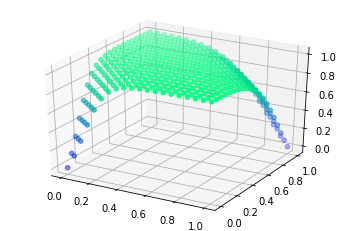

In [26]:
# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])

points = np.array(points)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=points[:, 2], cmap="winter")
plt.show()

#### Example: MNIST

In [27]:
def preprocess_data(x, y, limit):
    # reshape and normalize input data
    x = x.reshape(x.shape[0], 28 * 28, 1)
    x = x.astype("float32") / 255
    # encode output which is a number in range [0,9] into a vector of size 10
    # e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    y = np_utils.to_categorical(y)
    y = y.reshape(y.shape[0], 10, 1)
    return x[:limit], y[:limit]

In [43]:
# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
total_examples_train = 1000

total_examples_test = total_examples_train * .1
total_examples_test = int(total_examples_test)

In [45]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [31]:
x_train[0].shape

(28, 28)

##### Depicting examples

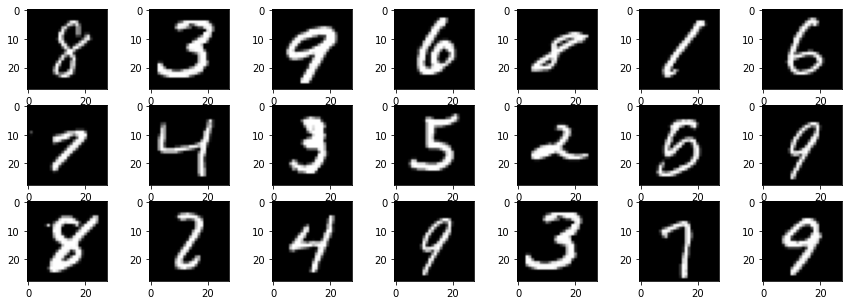

In [32]:
rows = 3
columns = 7

fig, axes = plt.subplots( rows, columns, figsize=( 15, 5 ) )

for i in range(rows):
  for j in range(columns):
    random_number = int(np.random.rand() * total_examples_train)
    axes[i][j].imshow( x_train[random_number], cmap='gray' )

plt.show()

##### Preprocessing Data

In [33]:
x_train, y_train = preprocess_data(x_train, y_train, total_examples_train)
x_test, y_test = preprocess_data(x_test, y_test, total_examples_test)

In [34]:
# neural network
network = [
    Dense(input_size = 28 * 28, 
          output_size = 40),
    Activation(activation = tanh, 
               activation_prime = tanh_prime),
    Dense(input_size = 40, 
          output_size = 10),
    Activation(activation = tanh,
               activation_prime = tanh_prime),
]

##### Training

In [35]:
%%time

train(network, 
      mse, 
      mse_prime, 
      x_train, 
      y_train, 
      epochs=1000, 
      learning_rate=0.1)

0/1000, error=0.883
100/1000, error=0.0696
200/1000, error=0.0571
300/1000, error=0.0519
400/1000, error=0.0475
500/1000, error=0.0446
600/1000, error=0.0424
700/1000, error=0.0409
800/1000, error=0.04
900/1000, error=0.0389
CPU times: user 4min 25s, sys: 3min 34s, total: 8min
Wall time: 4min 15s


In [36]:
# test
y_predicted = list()
y_actual = list()

for x, y in zip(x_test, y_test):
    output = predict(network, x)

    y_predicted.append( np.argmax(output) )
    y_actual.append( np.argmax(y) )

    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

pred: 7 	true: 7
pred: 6 	true: 2
pred: 1 	true: 1
pred: 6 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 6 	true: 4
pred: 6 	true: 9
pred: 6 	true: 5
pred: 6 	true: 9
pred: 3 	true: 0
pred: 8 	true: 6
pred: 6 	true: 9
pred: 6 	true: 0
pred: 1 	true: 1
pred: 9 	true: 5
pred: 6 	true: 9
pred: 7 	true: 7
pred: 6 	true: 3
pred: 4 	true: 4
pred: 6 	true: 9
pred: 6 	true: 6
pred: 4 	true: 6
pred: 3 	true: 5
pred: 4 	true: 4
pred: 0 	true: 0
pred: 7 	true: 7
pred: 4 	true: 4
pred: 6 	true: 0
pred: 1 	true: 1
pred: 3 	true: 3
pred: 1 	true: 1
pred: 3 	true: 3
pred: 6 	true: 4
pred: 7 	true: 7
pred: 2 	true: 2
pred: 7 	true: 7
pred: 1 	true: 1
pred: 2 	true: 2
pred: 1 	true: 1
pred: 1 	true: 1
pred: 7 	true: 7
pred: 6 	true: 4
pred: 2 	true: 2
pred: 3 	true: 3
pred: 3 	true: 5
pred: 6 	true: 1
pred: 2 	true: 2
pred: 6 	true: 4
pred: 4 	true: 4
pred: 6 	true: 6
pred: 3 	true: 3
pred: 4 	true: 5
pred: 3 	true: 5
pred: 6 	true: 6
pred: 6 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 6 	true:

##### Confusion Matrix

In [37]:
confusion_matrix = metrics.confusion_matrix(y_actual, y_predicted)
# print(confusion_matrix)

In [38]:
# based on https://www.statology.org/confusion-matrix-python/

y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')

#create confusion matrix
print(pd.crosstab(y_actual, y_predicted))

Predicted  0   1  2  3  4  6   7  8  9
Actual                                
0          3   0  0  1  0  4   0  0  0
1          0  12  0  0  0  1   0  1  0
2          0   0  5  0  0  2   1  0  0
3          0   0  0  9  0  2   0  0  0
4          0   0  0  0  8  6   0  0  0
5          0   0  0  3  1  2   0  0  1
6          0   0  0  0  1  8   0  1  0
7          0   0  0  0  0  1  14  0  0
8          0   0  0  0  0  1   0  1  0
9          0   0  0  0  0  9   1  1  0


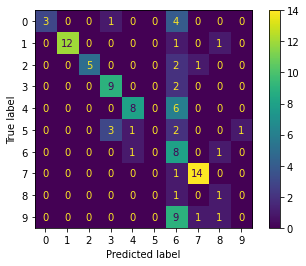

In [39]:
# based on https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix, 
    display_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm_display.plot()
plt.show()

In [40]:
y_err = y_predicted[ y_predicted != y_actual ]
y_err[:20]

1     6
3     6
6     6
7     6
8     6
9     6
10    3
11    8
12    6
13    6
15    9
16    6
18    6
20    6
22    4
23    3
28    6
33    6
42    6
45    3
Name: Predicted, dtype: int64

#### Valor da Taxa de Erro

"o valor da taxa de erro (calculada como o número de todas as previsões incorretas dividido pelo número total do conjunto de dados. A melhor taxa de erro é 0, enquanto a pior é 1.)"

In [41]:
error_rate = len(y_err) / total_examples_test
print( f'error_rate: {error_rate:.3}' )

error_rate: 0.4


In [42]:
error_rate_percentage = len(y_err) / total_examples_test * 100
print( f'error_rate_percentage: {error_rate_percentage:.3}%' )

error_rate_percentage: 40.0%
